## Decision Trees

**Objective**: This notebook follows the workflow from the logistic regression notebook to analyse customer reviews using Decision Tree classifiers to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed A Grid search to find the optimal setup for a Decision Tree on both the balanced and unbalanced data. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset and compare the results.

**Key Findings**:

In [1]:
# standard library imports
import joblib

# data handling and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (20, 10)

# machine learning and utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

# local source imports
from source import downsample_binary, my_tokenizer

# interpretability tools
import lime
import lime.lime_tabular


In [2]:
# feature union for the vectoriser, easiest way to guarantee 500 1-grams and 100 2-grams 
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

## Decision trees on the vectorized reviews
I will first downsample the train data as before, then optimize a decision tree model on the unbalanced data first, then the balanced data with a downsampled majority class and finally compare the results. I am using the vectorisation with 1 and 2-grams

In [3]:
# reading in the data
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")

In [4]:
# test train split before doing the downsampling
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
test_later = X_test

In [6]:
# function which downsamples the majority class in a dataframe

balanced_set = downsample_binary(y_train, X_train)

I keep an unvectorised train set and a prevectorised train set so that we can tune the hyperparamters with out having to apply the vectoriser every cross-validation, saving compute. I recognise that this leaks the validation set, however, the test set is kept hidden til evaltuation. 

In [7]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [8]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]
X_train_bal_unvec = balanced_set["reviewText"]


### Optimizing a Decision Tree Classifier on the original unbalanced data

I will use a grid search to find the best combination of:
- criterion: gini, entropy, (log_loss)
- max_depth
- min_samples_split
- min_samples_leaf
- max_features


In [23]:
# instansiate the pipeline for hyperparameter tuning (gridsearch)
estimators = [
              ('model', DecisionTreeClassifier(random_state=12))]

pipe = Pipeline(estimators)

In [24]:

params = {'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [5,10,15],
    'model__min_samples_leaf': [3,5]
    # 'model__min_samples_split':[5,10]
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [ ]:
# fit the first grid search
fitted_tree = grid_search.fit(X_train, y_train)

In [22]:
fitted_tree.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=3, random_state=12))],
         verbose=True)

In [16]:
# second parameter grid 
params2 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [15,25],
    'model__min_samples_leaf': [3,5]
    # 'model__min_samples_split':[5,10],
}

grid_search2 = GridSearchCV(pipe, param_grid=params2, verbose=3, n_jobs=2)

In [ ]:
# fitting second grid
fitted_tree2 = grid_search2.fit(X_train,y_train)

In [19]:
print(fitted_tree2.best_estimator_)

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)


In [40]:

params3 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [25,50],
    'model__min_samples_leaf': [5,10]
    # 'model__min_samples_split':[5,10]
}

grid_search3 = GridSearchCV(pipe, param_grid=params3, verbose=3, n_jobs=2)

In [ ]:
fitted_tree3 = grid_search3.fit(X_train,y_train)

In [42]:
fitted_tree3.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)

In [54]:
# fourth and final parameter search
params4 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [24,25,26],
    'model__min_samples_leaf': [5]    
}

grid_search4 = GridSearchCV(pipe, param_grid=params4, verbose=3, n_jobs=2)

In [ ]:
# fitting
fitted_tree4 = grid_search4.fit(X_train, y_train)

In [56]:
fitted_tree4.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)

I will set a final pipeline with the vectoriser and the best estimator found in the grid search. I can then serialize the model, so we can use it in other notebooks, as well as deploying it. (Streamlit app). The best estimator for the unbalanced decision tree was `DecisionTreeClassifier(max_depth=25, criterion="entropy", min_samples_leaf=5,random_state=12)`


In [9]:
estimators= [('vectorize', combined_features),
              ('model', DecisionTreeClassifier(max_depth=25, criterion="entropy", min_samples_leaf=5,random_state=12))]
pipe_final = Pipeline(estimators, verbose = True)

pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 4.1min
[Pipeline] ............. (step 2 of 2) Processing model, total=  30.1s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x28a126700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x28a126700>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)

### Optimizing a Decision Tree Classifier on the balanced data
Using the data with randomly downsampled majority class
I will use a grid search to find the best combination of:
- max_depth
- min_samples_split
- min_samples_leaf - turns out to be default


In [24]:
estimators_bal = [
              ('model', DecisionTreeClassifier(random_state=12))]
pipe_bal = Pipeline(estimators_bal)


In [25]:
# first param grid
params_bal = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [5,10,15],
    'model__min_samples_leaf': [3,5]
    # 'model__min_samples_split':[5,10],
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [ ]:
# fitting
fitted_tree_bal = grid_search_bal.fit(X_train_bal, y_train_bal)

In [28]:
fitted_tree_bal.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=5, random_state=12))])

In [29]:
# second param grid
params_bal2 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [15,20,25,30],
    'model__min_samples_leaf': [5]
    # 'model__min_samples_split':[5,10],
}

grid_search_bal2 = GridSearchCV(pipe_bal, param_grid=params_bal2, verbose=3, n_jobs=2)

In [ ]:
fitted_tree_bal2 = grid_search_bal2.fit(X_train_bal, y_train_bal)

In [32]:
print(fitted_tree_bal2.best_estimator_)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=30,
                                        min_samples_leaf=5, random_state=12))])


In [43]:

params_bal3 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [35,40,50],
    'model__min_samples_leaf': [10]
    # 'model__min_samples_split':[5,10],

    
    
}

grid_search_bal3 = GridSearchCV(pipe_bal, param_grid=params_bal3, verbose=3, n_jobs=2)

In [ ]:
fitted_tree_bal3 = grid_search_bal3.fit(X_train_bal, y_train_bal)

In [45]:
fitted_tree_bal3.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=10,
                                        random_state=12))])

In [46]:
fitted_tree_bal3.best_score_

0.7557870711235459

I will set a final pipeline with the vectoriser and the best estimator found in the grid search. I can then serialize the model, so we can use it in other notebooks, as well as deploying it. (Streamlit app)

In [10]:
estimators_final_bal= [('vectorize', combined_features),
              ('model', DecisionTreeClassifier(max_depth=40, criterion="entropy", min_samples_leaf=10,random_state=12))]
pipe_final_bal = Pipeline(estimators_final_bal, verbose = True)

pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 2.0min
[Pipeline] ............. (step 2 of 2) Processing model, total=  20.7s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x28a126700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x28a126700>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=10,
                                        random_state=12))],
         verbose=True)

In [11]:
# serialize
joblib.dump(pipe_final, "../model/decision-tree-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/decision-tree-bal-model.pkl")



['../model/decision-tree-bal-model.pkl']

In [13]:
# for loading in models without having to perform the .fit
# pipe_final = joblib.load("../model/decision-tree-unbal-model.pkl")
# pipe_final_bal=joblib.load("../model/decision-tree-bal-model.pkl")



# Evaluation:
1. Visualise beginning of trees
2. Feature importances
3. Confusion matricies and classification reports 
4. ROC
5. SHAP


We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [12]:
y_train_predicted = pipe_final.predict(X_train_unvec)
y_test_predicted = pipe_final.predict(X_test_unvec)
train_acc_unbal = accuracy_score(y_train, y_train_predicted)
test_acc_unbal= accuracy_score(y_test, y_test_predicted)


In [13]:
y_train_predicted_bal = pipe_final_bal.predict(X_train_bal_unvec)
y_test_predicted_bal = pipe_final_bal.predict(X_test_unvec)
train_acc_bal = accuracy_score(y_train_bal, y_train_predicted_bal)
test_acc_bal= accuracy_score(y_test, y_test_predicted_bal)


In [14]:
feature_unbal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final[0].get_feature_names_out())]
feature_bal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final_bal[0].get_feature_names_out())]

In [15]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [16]:
# normal
cm_unbal = confusion_matrix(y_test, y_test_predicted)
cm_unbal_norm = confusion_matrix(y_test, y_test_predicted, normalize="true")

In [17]:
# downsampled
cm_bal = confusion_matrix(y_test, y_test_predicted_bal)
cm_bal_norm = confusion_matrix(y_test, y_test_predicted_bal, normalize="true")

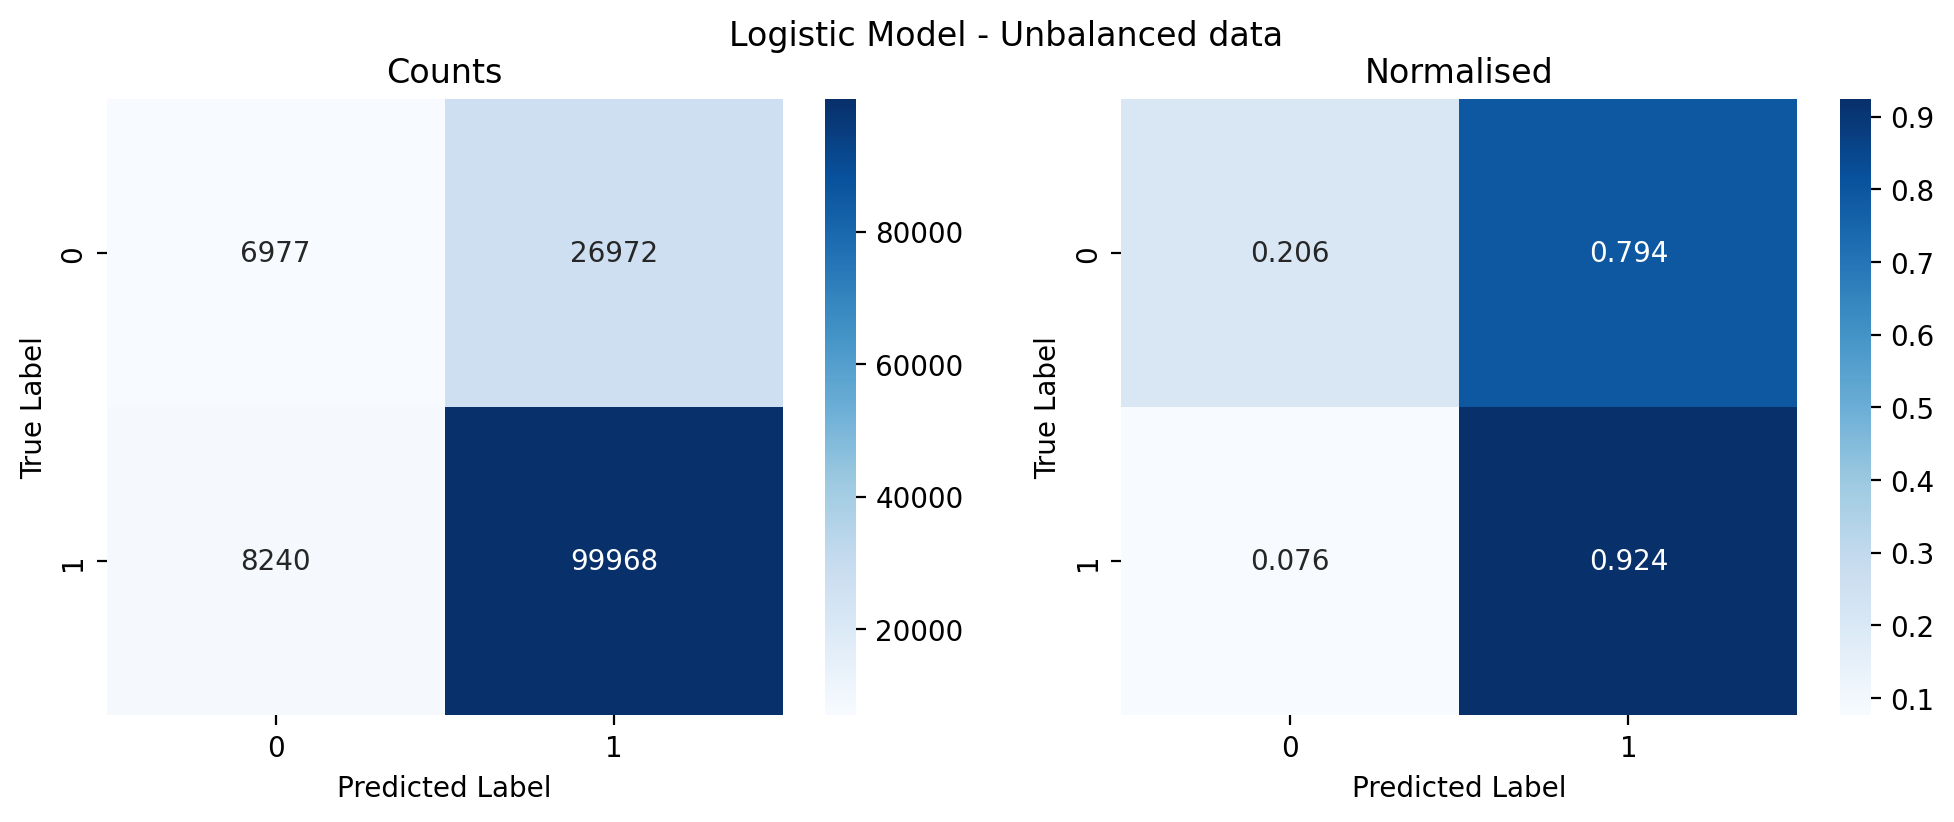

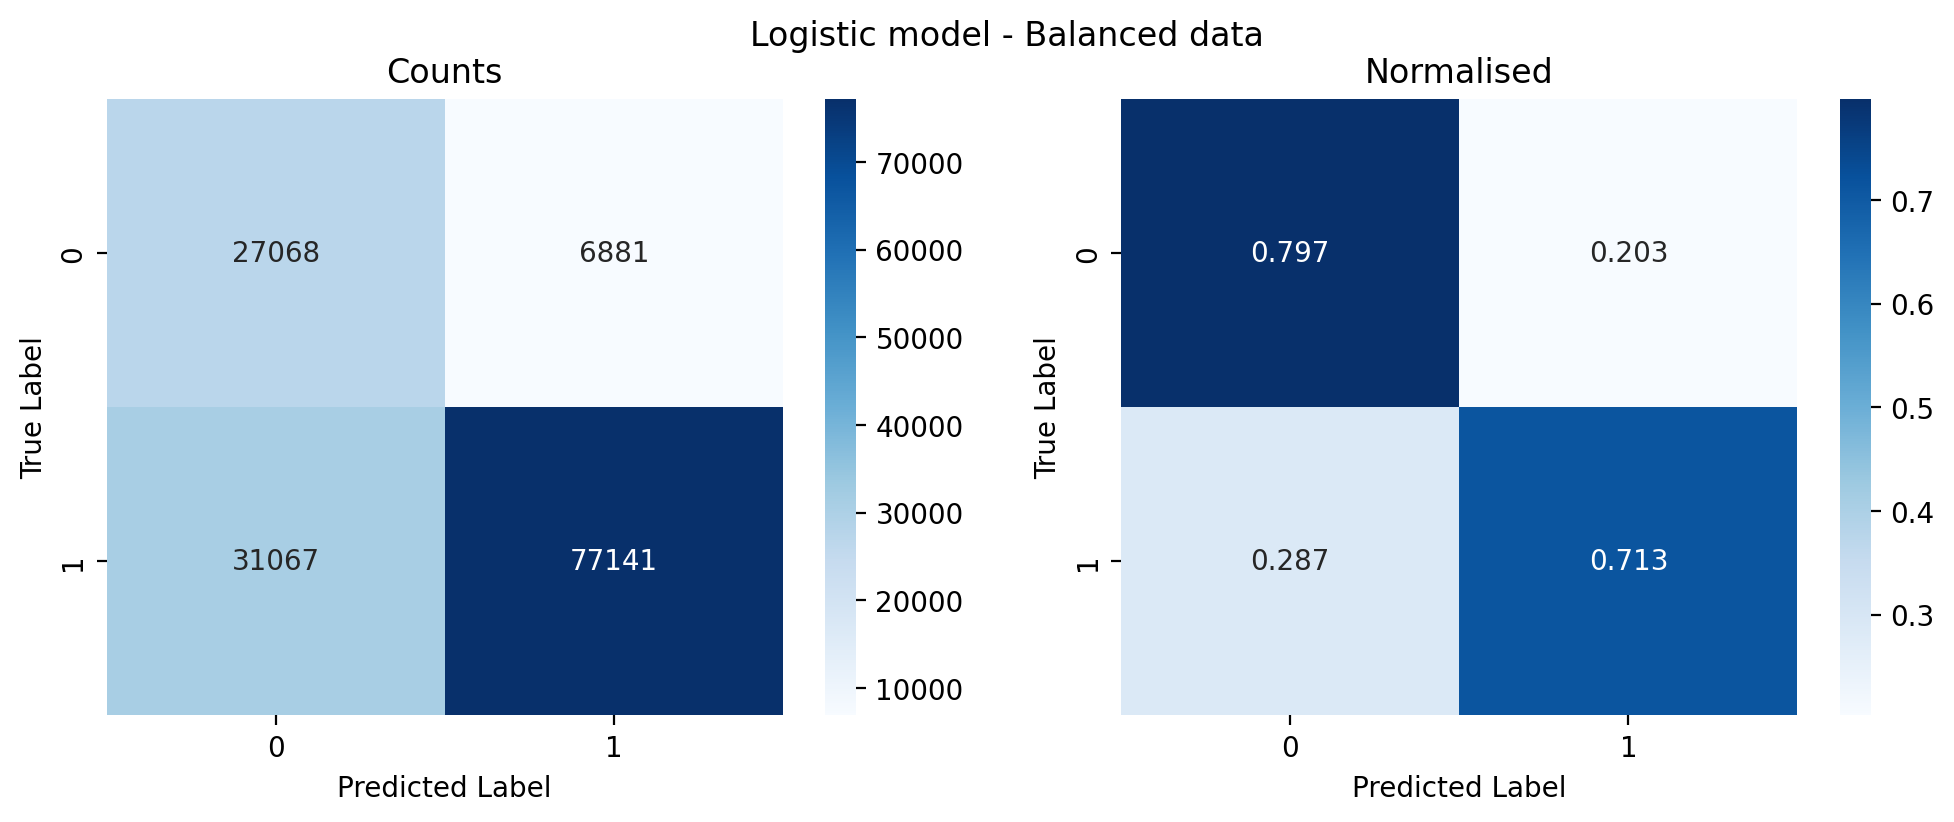

In [18]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_unbal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_unbal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Logistic Model - Unbalanced data")
plt.show()
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Logistic model - Balanced data")
plt.show()

In [19]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)

In [20]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


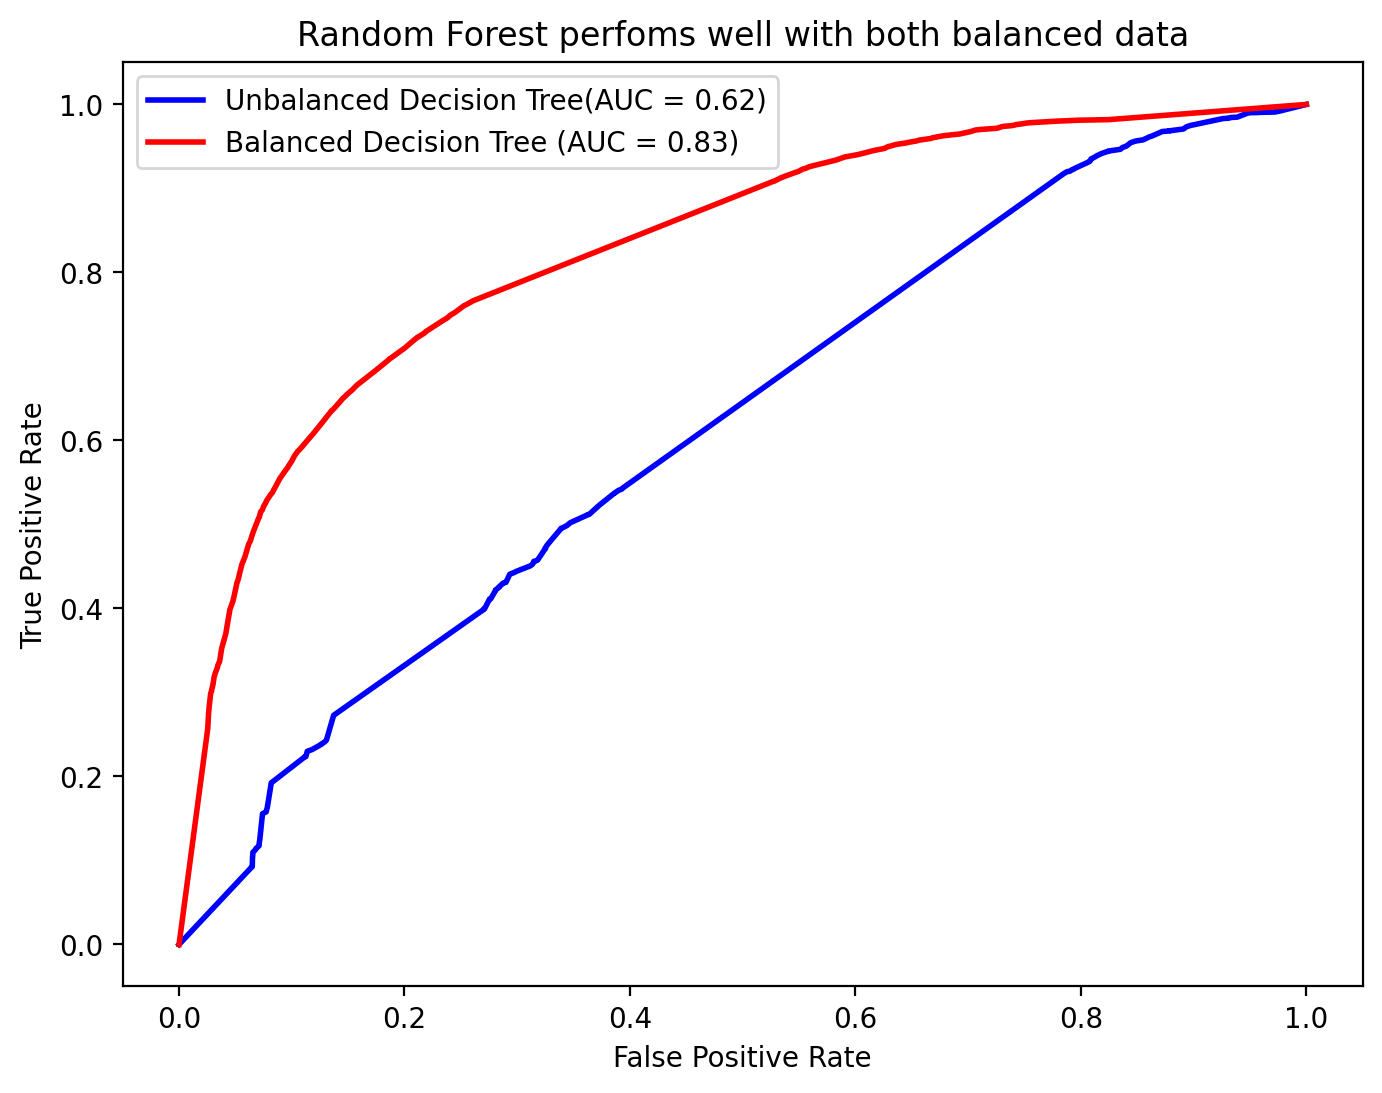

In [21]:
%config InlineBackend.figure_format="retina"
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced Decision Tree(AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced Decision Tree (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest perfoms well with both balanced data')
plt.legend()


plt.show()

In [22]:
print(classification_report(y_test, y_test_predicted))


              precision    recall  f1-score   support

           0       0.46      0.21      0.28     33949
           1       0.79      0.92      0.85    108208

    accuracy                           0.75    142157
   macro avg       0.62      0.56      0.57    142157
weighted avg       0.71      0.75      0.71    142157



In [23]:
print(classification_report(y_test, y_test_predicted_bal))

              precision    recall  f1-score   support

           0       0.47      0.80      0.59     33949
           1       0.92      0.71      0.80    108208

    accuracy                           0.73    142157
   macro avg       0.69      0.76      0.70    142157
weighted avg       0.81      0.73      0.75    142157



### Original unbalanced dataset:
- **Recall for negative reviews (0)**: The recall for the negative class is 0.21. This means that only 21% of the actual negative reviews were correctly identified by the model. This is even lower than the logistic regression and indicates that the model missed a large number of negative reviews.
- **Precision for negative reviews (0)**: The precision is 0.46, which indicates that out of all the reviews predicted as negative, only 46% were actually negative. This is veryy slightly better than the logistic regression.
- **Overall accuracy**: While the overall accuracy is 0.75, this is largely influenced by the model's performance on the dominant positive class. The high imbalance in the dataset makes accuracy a less reliable indicator of model performance.

### After downsampling the majority (1) class:
- **Recall for negative reviews (0)**: The recall increased to 0.80, indicating that the model now correctly identifies 80% of the negative reviews. This is a substantial improvement, showing that the model became much better at detecting negative reviews.
- **Precision for negative reviews (0)**: The precision for the negative class also improved to 0.47. This means a higher proportion of reviews predicted as negative are infact negative. Ideally this would be higher too, however the recall increasing so much is already a good improvement. We identified 80% of the negative reviews, and if the model identifies a review as negative, there is a 47% chance it is infact negative.
- **Overall Accuracy**: The overall accuracy decreased to 0.73, with a significant drop in recall of class 1. So it became better at guessing a negative review at the expense of a positive review.

### Observations:
1. **Improved Recall for Minority Class**: The most notable improvement is in the recall for the negative class, which suggests that balancing the classes helped the model to better identify the negative reviews.
   
### Conclusion:
Balancing the classes by downsampling the majority class significantly improved the model's ability to identify negative reviews without drastically compromising its ability to identify positive reviews. This change led to a more balanced and effective model, especially important in applications where detecting the minority class is crucial, like in sentiment analysis of customer reviews. This is also shown in the confusion matricies and the ROC curve.

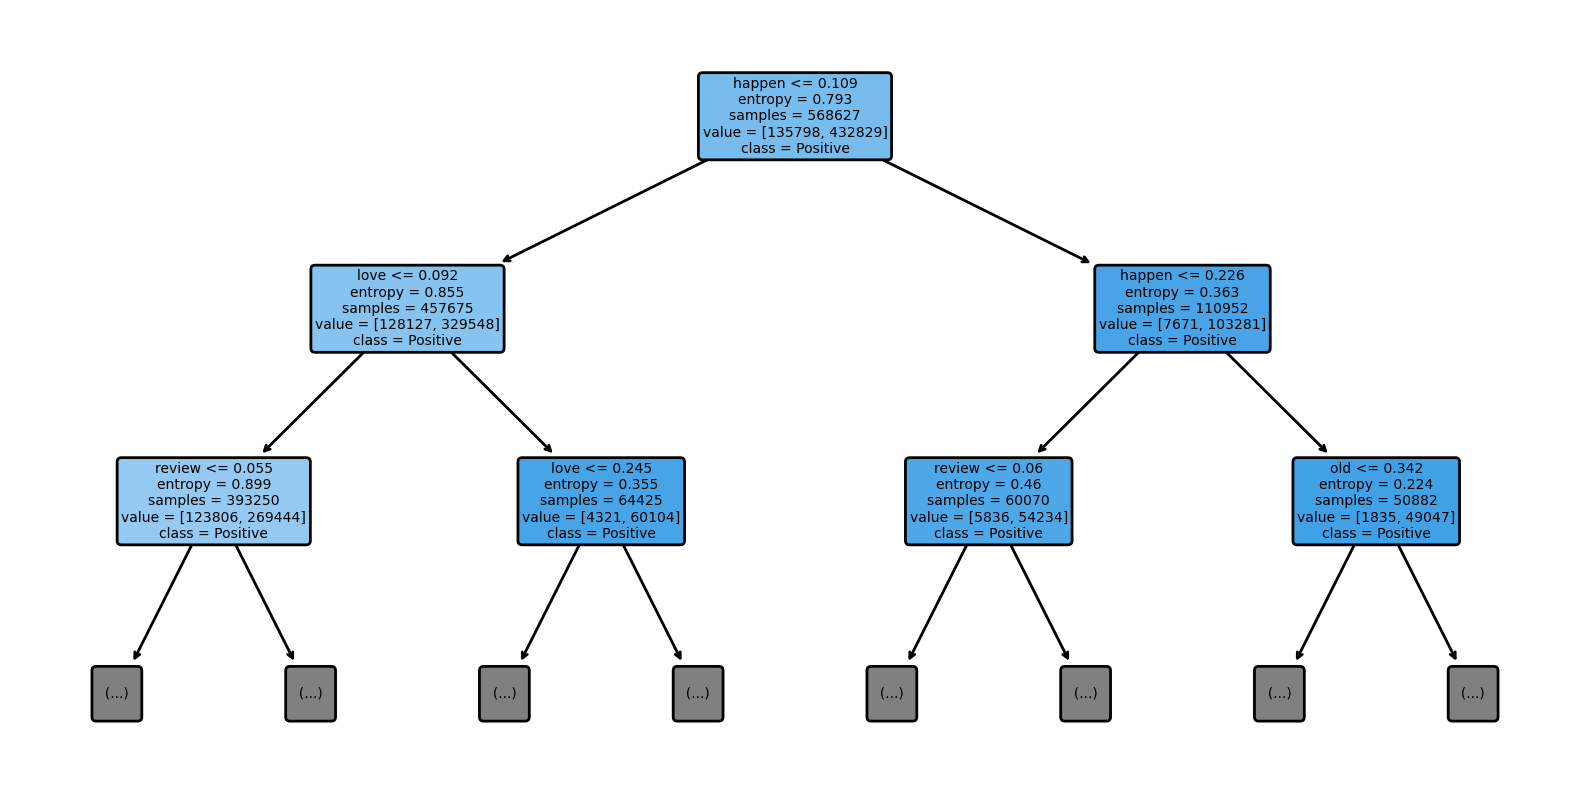

In [27]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier = pipe_final[-1]

plt.figure(figsize=(10, 5))
plot_tree(decision_tree_classifier, max_depth=2, filled=True, feature_names=feature_unbal, class_names=["Negative","Positive"], rounded=True)
plt.show()

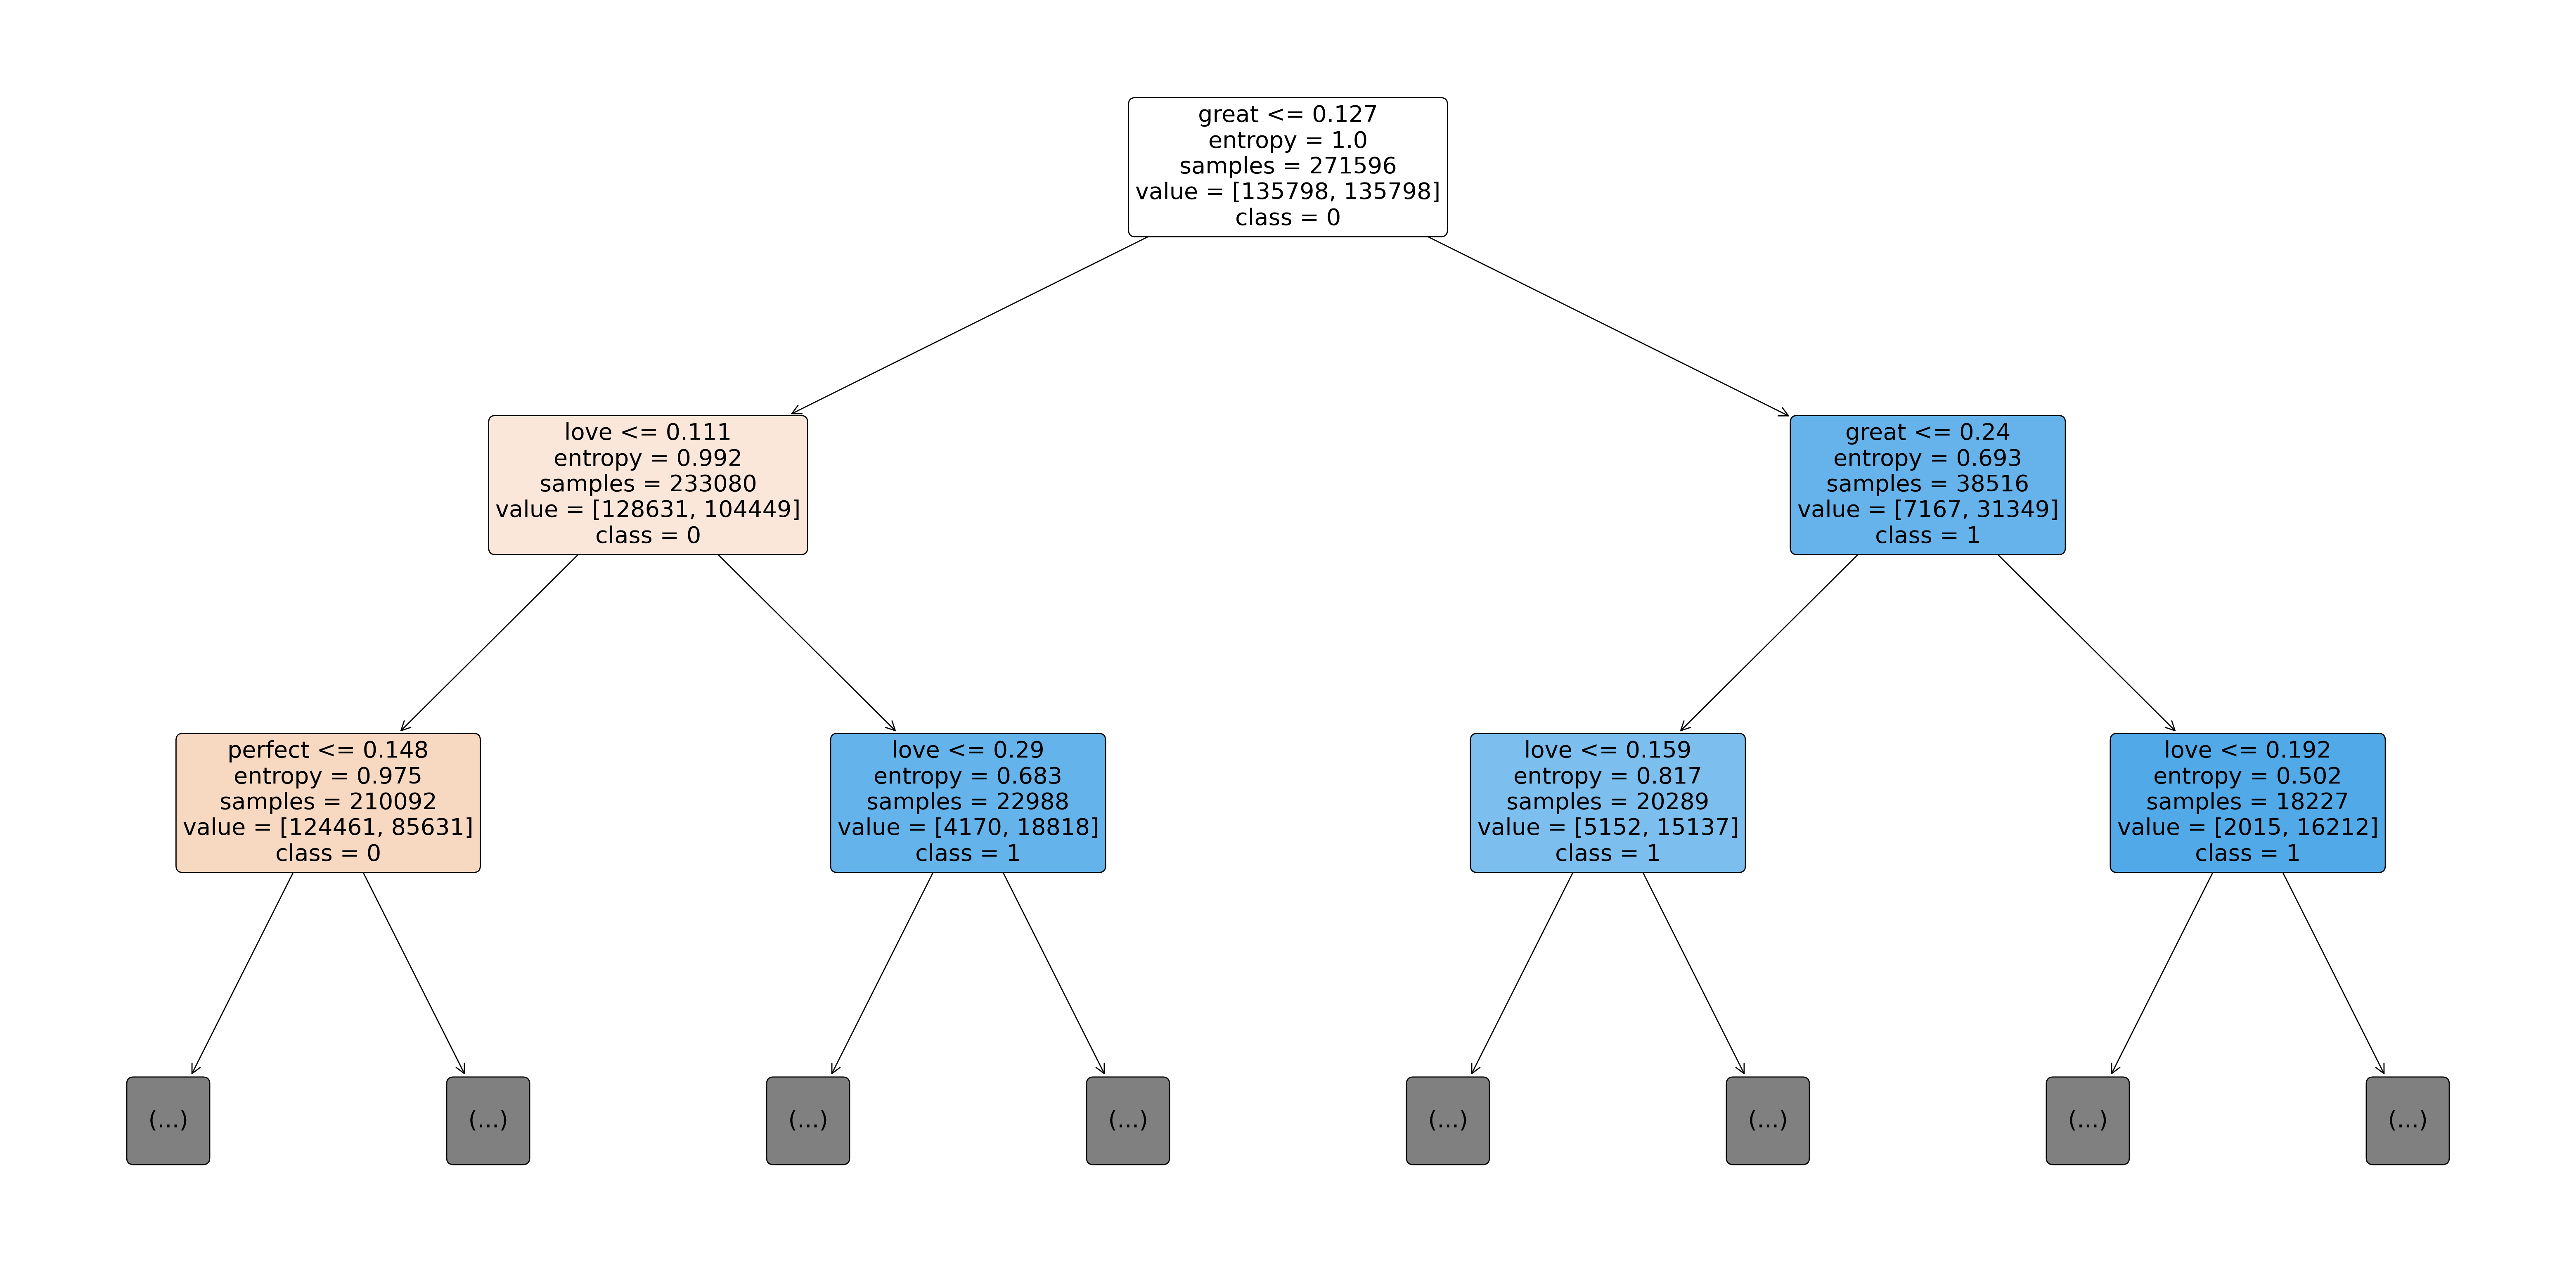

In [25]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier_bal = pipe_final_bal[-1]

plt.figure(figsize=(40, 20))
plot_tree(decision_tree_classifier_bal, max_depth=2, filled=True, feature_names=feature_bal, class_names=["0","1"], rounded=True)
plt.show()

Feature importance:

In [28]:
fi_unbal = decision_tree_classifier.feature_importances_

feature_imp_unbal = pd.DataFrame(fi_unbal.reshape(1,-1), columns=feature_unbal, index=['Importances']).T
sorted_imp_unbal = feature_imp_unbal.sort_values(by='Importances', ascending=False)

print(sorted_imp_unbal.head(10))

        Importances
happen     0.139810
love       0.114476
review     0.060567
broke      0.045404
phone      0.043398
note       0.029741
pictur     0.029401
wast       0.028983
half       0.028906
expect     0.028132


In [29]:
fi_bal = decision_tree_classifier_bal.feature_importances_

feature_imp_bal = pd.DataFrame(fi_bal.reshape(1,-1), columns=feature_bal, index=['Importances']).T
sorted_imp_bal = feature_imp_bal.sort_values(by='Importances', ascending=False)

print(sorted_imp_bal.head(10))

           Importances
great         0.137862
love          0.108646
perfect       0.041624
return        0.039322
broke         0.029606
perfectli     0.029015
excel         0.028993
good          0.028679
nice          0.028344
well          0.023496


In [52]:
with open('dt_roc_data.pkl', 'wb') as f:
    joblib.dump({'fpr_unbal': fpr_unbal, 'tpr_unbal': tpr_unbal, 'roc_auc1': roc_auc1,
                 'fpr_bal': fpr_bal, 'tpr_bal': tpr_bal, 'roc_auc2': roc_auc2}, f)

In [104]:
incorrect_guesses_unbal = y_test != y_test_predicted

incorrect_v_unbal = pd.Series(y_test)[incorrect_guesses_unbal]
pred_df_unbal = pd.DataFrame(y_test_predicted,y_test.index)
pred_df_unbal
ig_unbal = pd.concat([pred_df_unbal[incorrect_guesses_unbal],pd.Series(incorrect_v_unbal), test_later[incorrect_guesses_unbal]], axis=1)
ig_unbal.rename(columns={0:"guess"}, inplace=True)

In [71]:
false_positives_unbal = ig_unbal[ig_unbal["guess"]==1]

In [72]:
false_positives_unbal.index[:40]

Index([140610,  68902, 223051, 491928, 366333, 496264, 442516, 467540, 542615,
        76685, 199108, 610088,  10361, 466751, 310806, 509502, 677573, 270439,
       557222, 238007, 234545, 459699, 352727, 293123,  35778,  72203,  91328,
       427270, 361551, 687101, 332550,  19111, 500435, 109708, 137267, 186425,
       497812, 104677, 453076, 226657],
      dtype='int64')

In [79]:
rev_unbal = ig_unbal.loc[459699]
text_u = rev_unbal["reviewText"]
print(f"Actual: {rev_unbal['binary']}, Guess: {rev_unbal[0]}, Overall: {int(rev_unbal['overall'])}")
print(f"Review: {text_u}")

Actual: 0, Guess: 1, Overall: 1
Review: I hated this case. It would not fit on my phone while I had a thin screen protector on it without tearing the screen protector off. Sent it back the same day it arrived.


In [80]:

incorrect_guesses = y_test != y_test_predicted_bal

incorrect_v = pd.Series(y_test)[incorrect_guesses]
pred_df = pd.DataFrame(y_test_predicted_bal,y_test.index)
pred_df
ig = pd.concat([pred_df[incorrect_guesses],pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1)
ig.rename(columns={0:"guess"}, inplace=True)

In [81]:
false_positives = ig[ig["guess"]==1]

In [83]:
false_positives.index

Index([ 68902, 491928, 509502, 270439, 293123,  35778,  72203, 687101, 137267,
       497812,
       ...
       258490, 424894, 206406,  91182, 195305, 402691,  22198, 150692, 393261,
       528479],
      dtype='int64', length=6881)

In [84]:
rev = ig.loc[68902]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text}")

Actual: 0, Guess: 1, Overall: 2
Review: I love the colors, the case is not sturdy those! If you are going for looks this is a good choice but if you want something to actually protect your phone this is not a good choice!


In [85]:
feature_values = ig.loc[68902,"1gram__10":]


We see that this model is harder to interpret. It is looking for how the top words are weighed even though they don't appear in the review. So the scores for all these words would be 0 but it takes a while til it gets further in the tree. It seems it struggles with this task.

In [89]:
decision_path = decision_tree_classifier_bal.decision_path(X_test[0:1])

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [90]:
print(decision_path.toarray())


[[1 1 1 ... 0 0 0]]


In [94]:
paths_dense = decision_path.toarray()[0]

# Now, let's print the decision path for the first sample in X_test

# Nodes that were traversed by the first sample
nodes_traversed = [i for i, value in enumerate(paths_dense) if value == 1]

print(f"Nodes traversed by the first sample: {nodes_traversed}")

# To understand the decision at each node:
for node_id in nodes_traversed:
    # Check if this is a leaf node
    if decision_tree_classifier_bal.tree_.children_left[node_id] == decision_tree_classifier_bal.tree_.children_right[node_id]:
        print(f"Sample reached leaf node {node_id}, predicted class: {decision_tree_classifier_bal.tree_.value[node_id].argmax()}")
    else:
        # This is not a leaf node, print the feature and threshold used to split the node
        feature_index = decision_tree_classifier_bal.tree_.feature[node_id]
        feature_name = ig.columns[6:].str.replace('1gram__', '').str.replace('2gram__', '')[feature_index]
        threshold = decision_tree_classifier_bal.tree_.threshold[node_id]
        print(f"Node {node_id} split: ({feature_name} <= {threshold})")

Nodes traversed by the first sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 542, 543, 544, 545, 546, 554]
Node 0 split: (glass <= 0.12745638191699982)
Node 1 split: (loos <= 0.11138306185603142)
Node 2 split: (part <= 0.14807375520467758)
Node 3 split: (replac <= 0.048412080854177475)
Node 4 split: (everi <= 0.057168133556842804)
Node 5 split: (pay <= 0.1011769063770771)
Node 6 split: (broke <= 0.0360909067094326)
Node 7 split: (give <= 0.18880201131105423)
Node 8 split: (best <= 0.1279151663184166)
Node 9 split: (never <= 0.11348509043455124)
Node 10 split: (durabl <= 0.10341345891356468)
Node 11 split: (well <= 0.09081466123461723)
Node 12 split: (awesom <= 0.1391664445400238)
Node 13 split: (wast <= 0.12175257876515388)
Node 14 split: (design <= 0.18669277429580688)
Node 15 split: (ive use <= 0.12346016615629196)
Node 16 split: (difficult <= 0.05747810751199722)
Node 17 split: (cheap <= 0.15050407499074936)
Node 18 split: (